<a href="https://colab.research.google.com/github/RatchanonPa/Data-Warehouse-and-Big-Data-Analytics/blob/main/Modellimg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

plt.style.use('ggplot')
warnings.filterwarnings("ignore")

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.formula.api import *
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from scipy import stats

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
# Read the CSV files
winter_data = pd.read_csv('/content/drive/MyDrive/Bigdata/taxi_data_processed1.csv')
summer_data = pd.read_csv('/content/drive/MyDrive/Bigdata/taxi_data_processed7.csv')

# Optionally, you can add a column to differentiate between winter and summer data
winter_data['season'] = 'winter'
summer_data['season'] = 'summer'

# Combine winter and summer data if needed
all_data = pd.concat([winter_data, summer_data], ignore_index=True)

In [28]:
all_data.columns

Index(['VendorID', 'passenger_count', 'trip_distance', 'RatecodeID',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount',
       'tip_amount', 'tolls_amount', 'total_amount', 'congestion_surcharge',
       'airport_fee', 'date', 'time', 'weekday', 'duration', 'day_type',
       'tip_percent', 'time_desc', 'avg_temp', 'precip', 'windspeed', 'snow',
       'snowdepth', 'PUborough', 'DOborough', 'season', 'Airport_fee'],
      dtype='object')

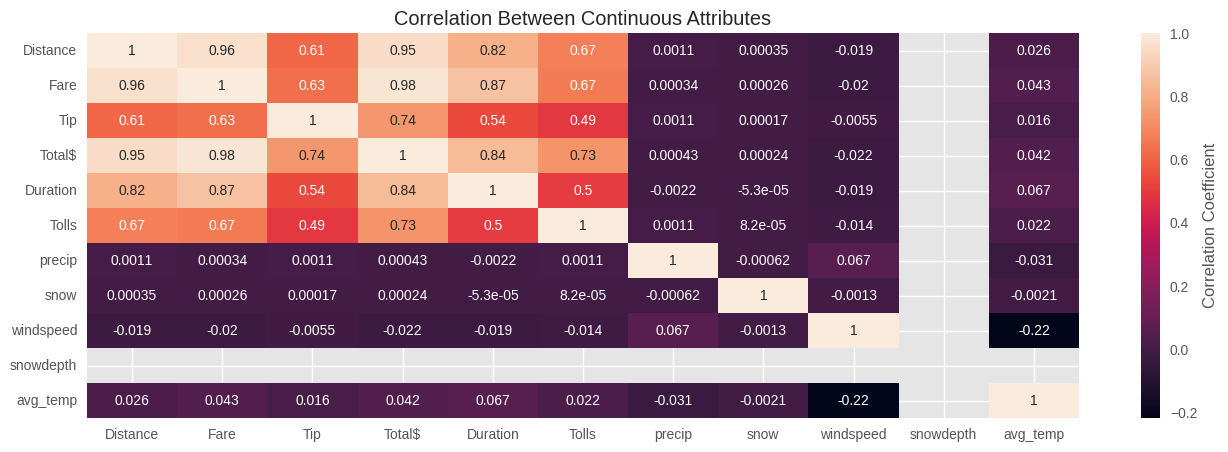

In [29]:
col = ['trip_distance', 'fare_amount', 'tip_amount', 'total_amount', 'duration', 'tolls_amount', 'precip', 'snow', 'windspeed', 'snowdepth', 'avg_temp']
label = ['Distance', 'Fare', 'Tip', 'Total$', 'Duration', 'Tolls', 'precip', 'snow', 'windspeed', 'snowdepth', 'avg_temp']

# plot correlation plot
fig, ax = plt.subplots(figsize=(16, 5))
corr_matrix = all_data[col].corr()
sns.heatmap(corr_matrix, annot=True, ax=ax, cbar_kws={'label': 'Correlation Coefficient'})
ax.set_xticklabels(label)
ax.set_yticklabels(label)
ax.set_title("Correlation Between Continuous Attributes")
plt.show()

In [30]:
# keep only card payment, since tip on cash payment is not recorded

sample = all_data[all_data['payment_type'] == 1].sample(frac=0.05, replace=True, random_state=30034).reset_index(drop=True)

In [31]:
COL = ['passenger_count', 'fare_amount', 'tip_amount', 'tolls_amount',
       'season', 'day_type', 'time_desc', 'PUborough', 'DOborough']
sample_filtered = sample.loc[:, COL].reset_index(drop=True)

In [32]:
# Split data to train and test
y = sample_filtered['tip_amount']
X_train, X_test, y_train, y_test = train_test_split(sample_filtered, y, test_size=0.3, random_state=0)

In [33]:
# Scale the continuous attributes
xCOLS = ['fare_amount', 'tolls_amount']

scaler = StandardScaler()
X_train[xCOLS] = scaler.fit_transform(X_train[xCOLS])
X_test[xCOLS] = scaler.transform(X_test[xCOLS])

In [34]:
# Baseline model which contains only the intercept

baseline = ols(formula='tip_amount ~ 1', data=X_train).fit()
print(baseline.summary())

                            OLS Regression Results                            
Dep. Variable:             tip_amount   R-squared:                      -0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Thu, 10 Oct 2024   Prob (F-statistic):                nan
Time:                        00:14:29   Log-Likelihood:            -4.2351e+05
No. Observations:              155545   AIC:                         8.470e+05
Df Residuals:                  155544   BIC:                         8.470e+05
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.2058      0.009    450.349      0.0

In [35]:

base_train_pred = baseline.predict(X_train)
base_test_pred = baseline.predict(X_test)
train_rmse = mean_squared_error(y_train, base_train_pred, squared=False)
test_rmse = mean_squared_error(y_test, base_test_pred, squared=False)

print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)

Train RMSE: 3.6831996746215485
Test RMSE: 3.6543197745096223


In [36]:
# fit the model
full_model = ols(formula='tip_amount ~ C(passenger_count) + fare_amount + tolls_amount + season + time_desc + day_type + PUborough + DOborough', data=X_train).fit()
print(full_model.summary())

                            OLS Regression Results                            
Dep. Variable:             tip_amount   R-squared:                       0.641
Model:                            OLS   Adj. R-squared:                  0.641
Method:                 Least Squares   F-statistic:                 1.157e+04
Date:                Thu, 10 Oct 2024   Prob (F-statistic):               0.00
Time:                        00:14:33   Log-Likelihood:            -3.4385e+05
No. Observations:              155545   AIC:                         6.878e+05
Df Residuals:                  155520   BIC:                         6.880e+05
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

In [37]:
# predict and evaluate
full_train_pred = full_model.predict(X_train)
full_test_pred = full_model.predict(X_test)
train_rmse = mean_squared_error(y_train, full_train_pred, squared=False)
test_rmse = mean_squared_error(y_test, full_test_pred, squared=False)
train_r2 = r2_score(y_train, full_train_pred)
test_r2 = r2_score(y_test, full_test_pred)

print("Full model")
print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)
print("Train R2", train_r2)
print("Test R2", test_r2)

Full model
Train RMSE: 2.207140650692435
Test RMSE: 2.159246787327538
Train R2 0.6409048892765822
Test R2 0.6508657338675623


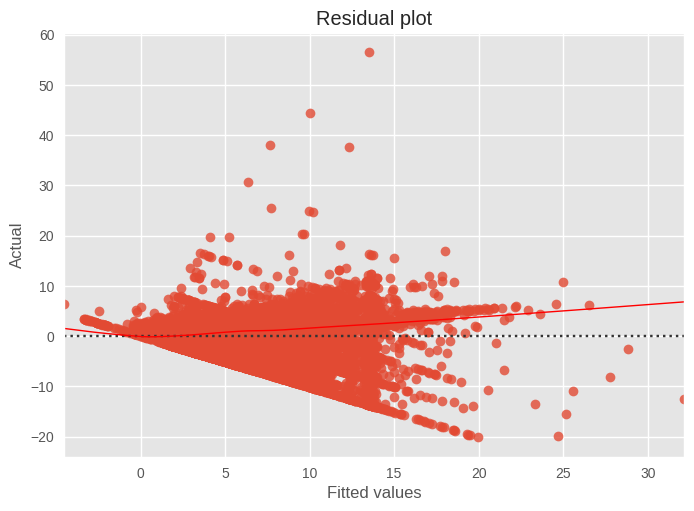

In [38]:
!pip install seaborn
!pip install statsmodels
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'full_test_pred' and 'y_test' are NumPy arrays or pandas Series
# Create a DataFrame for residplot
residual_data = {'Predicted': full_test_pred, 'Actual': y_test}
residual_df = pd.DataFrame(residual_data)

sns.residplot(x='Predicted', y='Actual', data=residual_df, lowess=True, line_kws={'color': 'red', 'lw': 1, 'alpha': 1})
plt.xlabel("Fitted values")
plt.title('Residual plot')
plt.show()

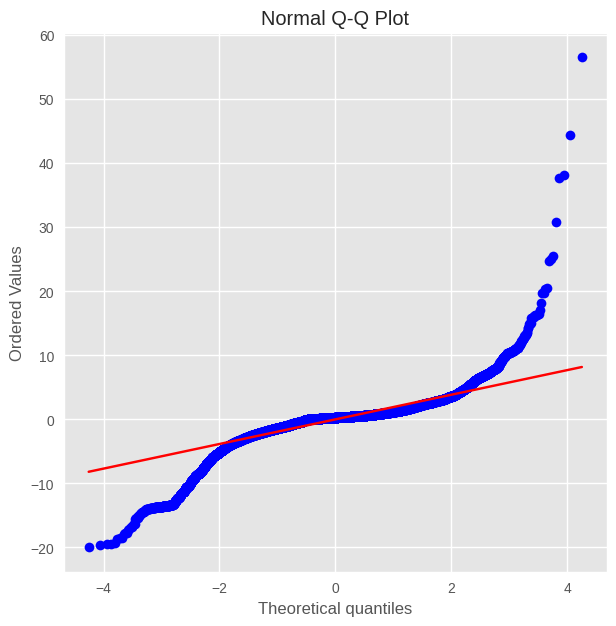

In [39]:
residuals = y_test - full_test_pred

plt.figure(figsize=(7,7))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Normal Q-Q Plot")
plt.show()

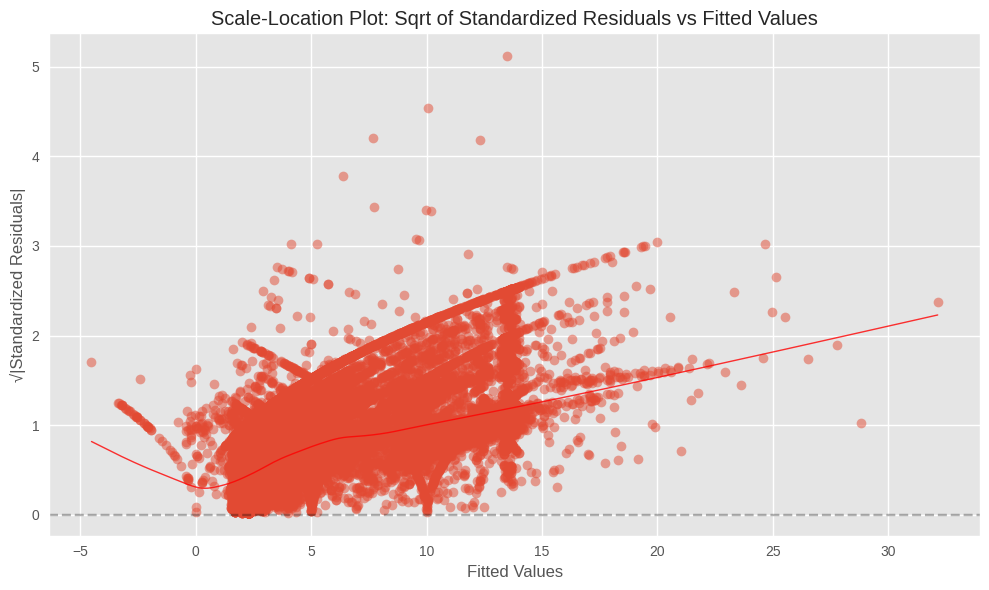

In [40]:
# Calculate standardized residuals manually
residuals = y_test - full_test_pred
std_residuals = residuals / np.std(residuals)
std_residuals_abs_sqrt = np.sqrt(np.abs(std_residuals))

# Create DataFrame for plotting
plot_data = pd.DataFrame({
    'Fitted': full_test_pred,
    'Residuals': std_residuals_abs_sqrt
})

# Create the plot
plt.figure(figsize=(10, 6))
sns.regplot(x='Fitted',
            y='Residuals',
            data=plot_data,
            scatter=True,
            scatter_kws={'alpha':0.5},
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

# Customize the plot
plt.title('Scale-Location Plot: Sqrt of Standardized Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('√|Standardized Residuals|')

# Add a horizontal line at y=0 for reference
plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)

# Adjust layout and display
plt.tight_layout()
plt.show()

## Gradient Boost Regression


Gradient Boosting Results:
--------------------------
Train RMSE: 2.1323
Test RMSE: 2.1429
Train R²: 0.6648
Test R²: 0.6561


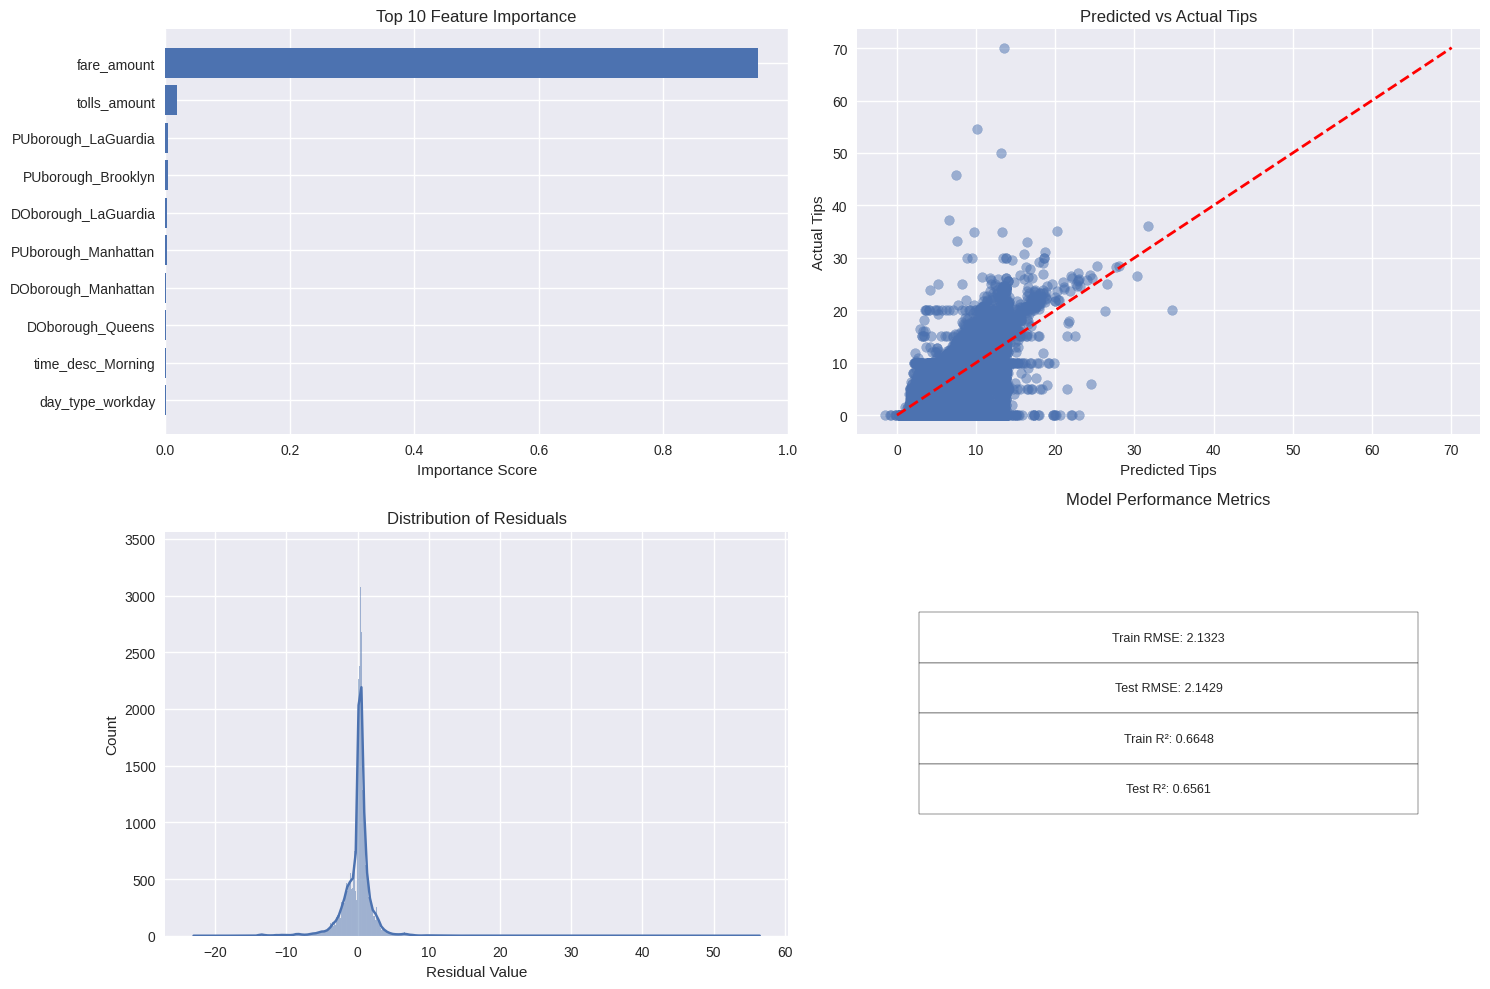


Top 5 Most Important Features:
------------------------------
fare_amount: 0.9530
tolls_amount: 0.0185
PUborough_LaGuardia: 0.0049
PUborough_Brooklyn: 0.0047
DOborough_LaGuardia: 0.0027


In [47]:
# 1. First ensure X_train and X_test are properly scaled
scaler = StandardScaler()
numeric_features = ['fare_amount', 'tolls_amount']
X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

# 2. Initialize and train the Gradient Boosting model
reg = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    min_samples_split=5,
    min_samples_leaf=3,
    random_state=42
)

# 3. Fit the model
reg.fit(X_train, y_train)

# 4. Make predictions
gbr_train_pred = reg.predict(X_train)
gbr_test_pred = reg.predict(X_test)

# 5. Calculate performance metrics
train_rmse = mean_squared_error(y_train, gbr_train_pred, squared=False)
test_rmse = mean_squared_error(y_test, gbr_test_pred, squared=False)
train_r2 = r2_score(y_train, gbr_train_pred)
test_r2 = r2_score(y_test, gbr_test_pred)

# 6. Print the results
print("\nGradient Boosting Results:")
print("--------------------------")
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Train R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")

# 7. Create visualization of results
plt.style.use('seaborn')
fig = plt.figure(figsize=(15, 10))
gs = fig.add_gridspec(2, 2)

# 7.1 Feature Importance Plot
ax1 = fig.add_subplot(gs[0, 0])
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': reg.feature_importances_
})
importance_df = importance_df.sort_values('importance', ascending=True)
importance_df_plot = importance_df.tail(10)  # Top 10 features

# Fixed: Using matplotlib's barh instead of seaborn's
ax1.barh(y=importance_df_plot['feature'], width=importance_df_plot['importance'])
ax1.set_title('Top 10 Feature Importance')
ax1.set_xlabel('Importance Score')

# 7.2 Predicted vs Actual Plot
ax2 = fig.add_subplot(gs[0, 1])
ax2.scatter(gbr_test_pred, y_test, alpha=0.5)
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
ax2.set_xlabel('Predicted Tips')
ax2.set_ylabel('Actual Tips')
ax2.set_title('Predicted vs Actual Tips')

# 7.3 Residuals Plot
ax3 = fig.add_subplot(gs[1, 0])
residuals = y_test - gbr_test_pred
sns.histplot(residuals, kde=True, ax=ax3)
ax3.set_title('Distribution of Residuals')
ax3.set_xlabel('Residual Value')

# 7.4 Model Performance Metrics
ax4 = fig.add_subplot(gs[1, 1])
metrics = {
    'Metric': ['Train RMSE', 'Test RMSE', 'Train R²', 'Test R²'],
    'Value': [train_rmse, test_rmse, train_r2, test_r2]
}
ax4.axis('off')
metrics_table = ax4.table(cellText=[[f'{k}: {v:.4f}'] for k, v in zip(metrics['Metric'], metrics['Value'])],
                         loc='center', cellLoc='center', bbox=[0.1, 0.3, 0.8, 0.5])
metrics_table.auto_set_font_size(False)
metrics_table.set_fontsize(9)
metrics_table.scale(1.5, 2)
ax4.set_title('Model Performance Metrics', pad=20)

plt.tight_layout()
plt.show()

# 8. Print feature importance summary
print("\nTop 5 Most Important Features:")
print("------------------------------")
for _, row in importance_df.tail(5).iloc[::-1].iterrows():
    print(f"{row['feature']}: {row['importance']:.4f}")

Performing hyperparameter tuning...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best Parameters:
{'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': None}

Random Forest Results:
--------------------------
Train RMSE: 2.1117
Test RMSE: 2.1585
Train R²: 0.6713
Test R²: 0.6511


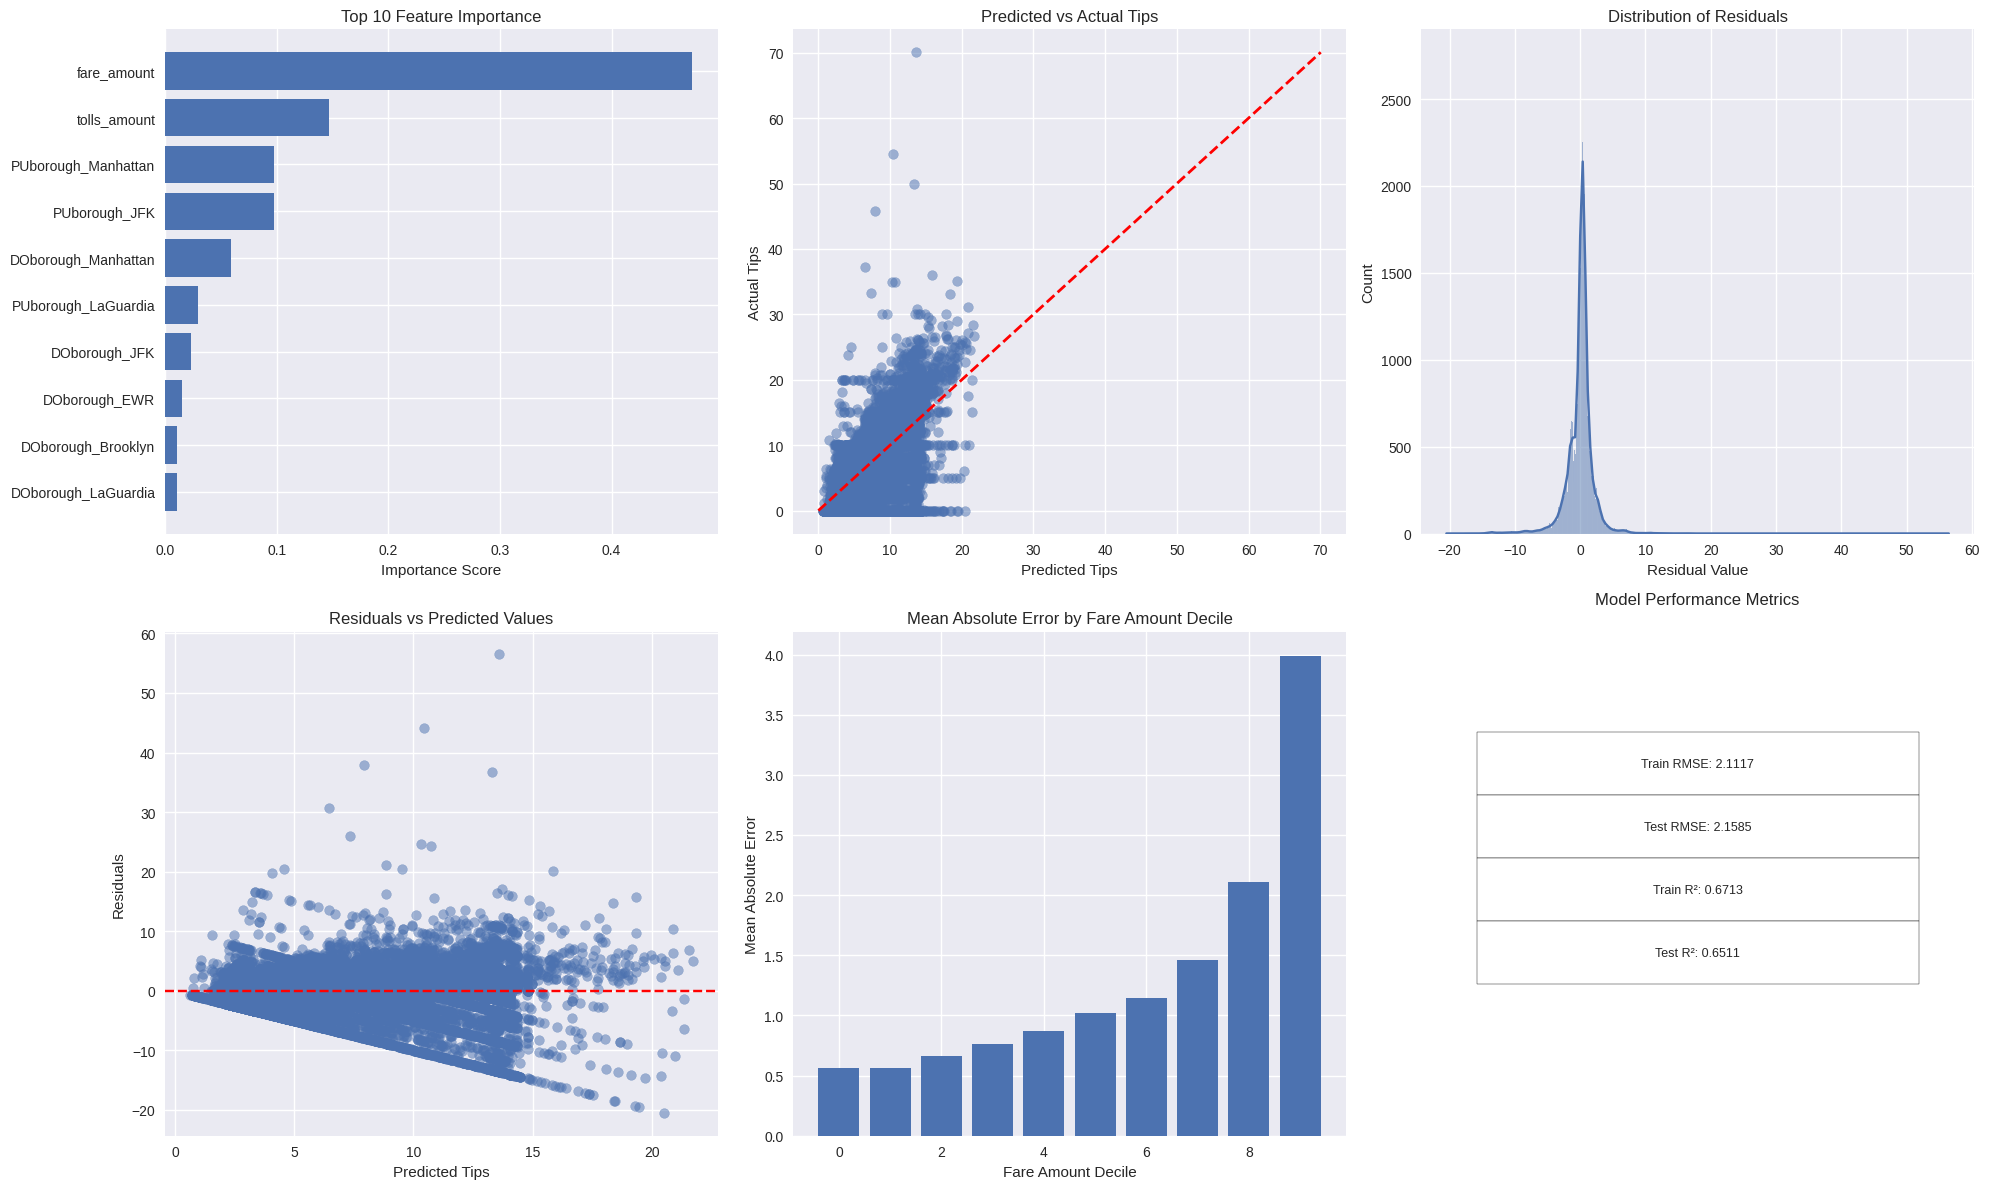


Top 10 Most Important Features:
------------------------------
fare_amount: 0.4716
tolls_amount: 0.1465
PUborough_Manhattan: 0.0977
PUborough_JFK: 0.0973
DOborough_Manhattan: 0.0590
PUborough_LaGuardia: 0.0298
DOborough_JFK: 0.0234
DOborough_EWR: 0.0154
DOborough_Brooklyn: 0.0107
DOborough_LaGuardia: 0.0104


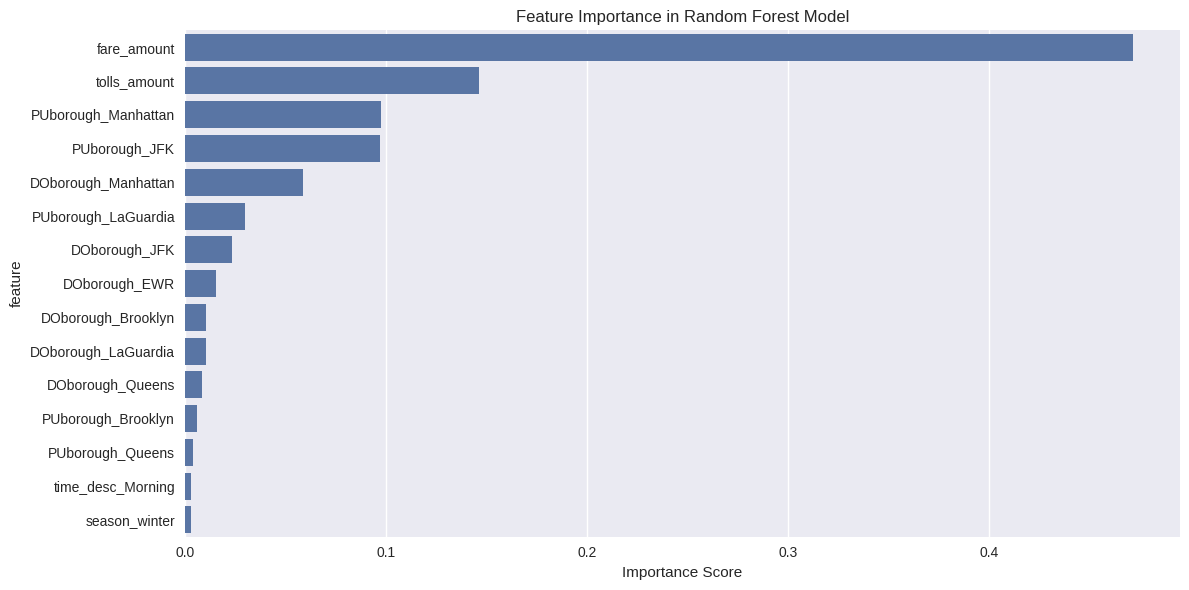

['random_forest_model.joblib']

In [48]:
# Import necessary libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score

# 1. First ensure X_train and X_test are properly scaled
scaler = StandardScaler()
numeric_features = ['fare_amount', 'tolls_amount']
X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

# 2. Initialize and train the Random Forest model with hyperparameter tuning
# Define the parameter grid for random search
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [10, 20, 30, 40, 50, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}

# Initialize Random Forest model
rf = RandomForestRegressor(random_state=42)

# Perform random search for hyperparameter tuning
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=20,
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit the random search model
print("Performing hyperparameter tuning...")
random_search.fit(X_train, y_train)

# Get the best model
best_rf = random_search.best_estimator_

# Print best parameters
print("\nBest Parameters:")
print(random_search.best_params_)

# 3. Make predictions
rf_train_pred = best_rf.predict(X_train)
rf_test_pred = best_rf.predict(X_test)

# 4. Calculate performance metrics
train_rmse = mean_squared_error(y_train, rf_train_pred, squared=False)
test_rmse = mean_squared_error(y_test, rf_test_pred, squared=False)
train_r2 = r2_score(y_train, rf_train_pred)
test_r2 = r2_score(y_test, rf_test_pred)

# 5. Print the results
print("\nRandom Forest Results:")
print("--------------------------")
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Train R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")

# 6. Create visualization of results
plt.style.use('seaborn')
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(2, 3)

# 6.1 Feature Importance Plot
ax1 = fig.add_subplot(gs[0, 0])
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_rf.feature_importances_
})
importance_df = importance_df.sort_values('importance', ascending=True)
importance_df_plot = importance_df.tail(10)  # Top 10 features

ax1.barh(y=importance_df_plot['feature'], width=importance_df_plot['importance'])
ax1.set_title('Top 10 Feature Importance')
ax1.set_xlabel('Importance Score')

# 6.2 Predicted vs Actual Plot
ax2 = fig.add_subplot(gs[0, 1])
ax2.scatter(rf_test_pred, y_test, alpha=0.5)
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
ax2.set_xlabel('Predicted Tips')
ax2.set_ylabel('Actual Tips')
ax2.set_title('Predicted vs Actual Tips')

# 6.3 Residuals Plot
ax3 = fig.add_subplot(gs[0, 2])
residuals = y_test - rf_test_pred
sns.histplot(residuals, kde=True, ax=ax3)
ax3.set_title('Distribution of Residuals')
ax3.set_xlabel('Residual Value')

# 6.4 Residuals vs Predicted Plot
ax4 = fig.add_subplot(gs[1, 0])
ax4.scatter(rf_test_pred, residuals, alpha=0.5)
ax4.axhline(y=0, color='r', linestyle='--')
ax4.set_xlabel('Predicted Tips')
ax4.set_ylabel('Residuals')
ax4.set_title('Residuals vs Predicted Values')

# 6.5 Error Distribution by Fare Amount
ax5 = fig.add_subplot(gs[1, 1])
fare_bins = pd.qcut(X_test['fare_amount'], q=10)
mean_errors = pd.DataFrame({
    'fare_bin': fare_bins,
    'abs_error': np.abs(residuals)
}).groupby('fare_bin')['abs_error'].mean()

ax5.bar(range(len(mean_errors)), mean_errors)
ax5.set_title('Mean Absolute Error by Fare Amount Decile')
ax5.set_xlabel('Fare Amount Decile')
ax5.set_ylabel('Mean Absolute Error')

# 6.6 Model Performance Metrics
ax6 = fig.add_subplot(gs[1, 2])
metrics = {
    'Metric': ['Train RMSE', 'Test RMSE', 'Train R²', 'Test R²'],
    'Value': [train_rmse, test_rmse, train_r2, test_r2]
}
ax6.axis('off')
metrics_table = ax6.table(cellText=[[f'{k}: {v:.4f}'] for k, v in zip(metrics['Metric'], metrics['Value'])],
                         loc='center', cellLoc='center', bbox=[0.1, 0.3, 0.8, 0.5])
metrics_table.auto_set_font_size(False)
metrics_table.set_fontsize(9)
metrics_table.scale(1.5, 2)
ax6.set_title('Model Performance Metrics', pad=20)

plt.tight_layout()
plt.show()

# 7. Print feature importance summary
print("\nTop 10 Most Important Features:")
print("------------------------------")
for _, row in importance_df.tail(10).iloc[::-1].iterrows():
    print(f"{row['feature']}: {row['importance']:.4f}")

# 8. Additional Analysis: Feature Importance Visualization
plt.figure(figsize=(12, 6))
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_rf.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

sns.barplot(x='importance', y='feature', data=feature_importance.head(15))
plt.title('Feature Importance in Random Forest Model')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

# 9. Save the model if needed
import joblib
joblib.dump(best_rf, 'random_forest_model.joblib')


Model Comparison:
----------------
            Model  Train MAE  Test MAE  Train RMSE  Test RMSE  Train R²  Test R²
         Baseline     2.3999    2.3913      2.1117     2.1585    0.0000   0.0000
Linear Regression     1.2998    1.2843      2.1117     2.1585    0.6713   0.6511
              KNN     1.3081    1.3734      2.1792     2.3138    0.6499   0.5991


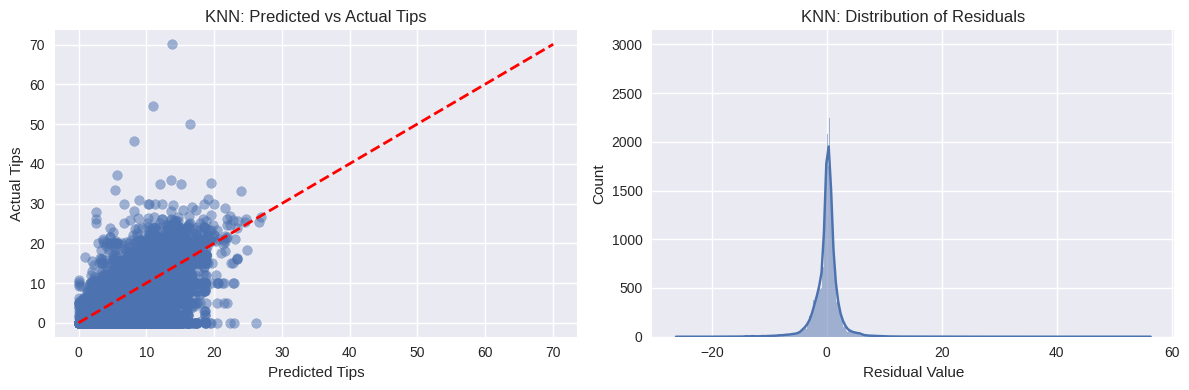

In [49]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Scale the features for KNN
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train KNN model
knn = KNeighborsRegressor(n_neighbors=5, weights='uniform')
knn.fit(X_train_scaled, y_train)

# Make predictions
knn_train_pred = knn.predict(X_train_scaled)
knn_test_pred = knn.predict(X_test_scaled)

# Calculate metrics for KNN
knn_train_mae = mean_absolute_error(y_train, knn_train_pred)
knn_test_mae = mean_absolute_error(y_test, knn_test_pred)
knn_train_rmse = mean_squared_error(y_train, knn_train_pred, squared=False)
knn_test_rmse = mean_squared_error(y_test, knn_test_pred, squared=False)
knn_train_r2 = r2_score(y_train, knn_train_pred)
knn_test_r2 = r2_score(y_test, knn_test_pred)

# Calculate MAE for the baseline model
base_train_mae = mean_absolute_error(y_train, base_train_pred)
base_test_mae = mean_absolute_error(y_test, base_test_pred)

# Calculate MAE for the full linear model
full_train_mae = mean_absolute_error(y_train, full_train_pred)
full_test_mae = mean_absolute_error(y_test, full_test_pred)

# Create comparison DataFrame
model_comparison = pd.DataFrame({
    'Model': ['Baseline', 'Linear Regression', 'KNN'],
    'Train MAE': [base_train_mae, full_train_mae, knn_train_mae],
    'Test MAE': [base_test_mae, full_test_mae, knn_test_mae],
    'Train RMSE': [train_rmse, train_rmse, knn_train_rmse],
    'Test RMSE': [test_rmse, test_rmse, knn_test_rmse],
    'Train R²': [0, train_r2, knn_train_r2],
    'Test R²': [0, test_r2, knn_test_r2]
})

# Round all numeric columns to 4 decimal places
numeric_columns = model_comparison.select_dtypes(include=[np.number]).columns
model_comparison[numeric_columns] = model_comparison[numeric_columns].round(4)

print("\nModel Comparison:")
print("----------------")
print(model_comparison.to_string(index=False))

# Visualize predictions vs actual values for KNN
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 4))

# Plot 1: Predicted vs Actual
plt.subplot(1, 2, 1)
plt.scatter(knn_test_pred, y_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Predicted Tips')
plt.ylabel('Actual Tips')
plt.title('KNN: Predicted vs Actual Tips')

# Plot 2: Residuals Distribution
plt.subplot(1, 2, 2)
residuals = y_test - knn_test_pred
sns.histplot(residuals, kde=True)
plt.title('KNN: Distribution of Residuals')
plt.xlabel('Residual Value')

plt.tight_layout()
plt.show()